# Numerical Evaluation

In this notebook, I will apply the evaluation methods to a numerical dataset called 'BIKE DETAILS' which is used for predicting the prices of motorbikes.

In [47]:
import pandas as pd

# load BIKE DETAIL data
df = pd.read_csv('BIKE DETAILS.csv')

# drop unnecessary column
df = df.drop('name',axis=1)

# change text values into numbers
df['owner'] = df['owner'].replace({'1st owner': 1, '2nd owner': 2, '3rd owner': 3, '4th owner': 4})

# make the seller type into dummies - I will work with them as dummies from here on 
seller_type_dummies = pd.get_dummies(df['seller_type'], prefix='seller_type_')
seller_type_dummies = seller_type_dummies.astype(float) 

# concatenate the dummy variables with the DataFrame
df = pd.concat([df, seller_type_dummies], axis=1)
df = df.drop('seller_type', axis=1)

# drop missing values
df = df.dropna()

### Split the dataset into three parts, namely training, validation and test. Prepare the three datasets to be analysed by creating for each the dependent variable and the design matrix - remember to account for the intercept. 

In [48]:
from statsmodels.api import add_constant
from sklearn.model_selection import train_test_split

# Add an intercept
df = add_constant(df)

# Split into training (50%) and temporary (50%)
train_df, temp_df = train_test_split(df, test_size=0.5, random_state=42)

# Split temporary into validation (25%) and test (25%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Design matrix of dependent variables
# Training data
train_y = train_df["selling_price"]
train_X = train_df.drop(columns=["selling_price"])

# Validation data
valid_y = val_df["selling_price"]
valid_X = val_df.drop(columns=["selling_price"])

# Test data
test_y = test_df["selling_price"]
test_X = test_df.drop(columns=["selling_price"])


### Build a function to evaluate the quality of a linear regression model predictions fit to a training set, on a validation set. Use Bias, RMSE, Correlation, and Coverage as the metrics of choice. 

In [49]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims=1000):

    # Fit the model
    model = sm.OLS(train_y, train_X).fit()

    # Extract model parameters
    betas = model.params
    beta_cov = model.cov_params()
    residual_std = np.sqrt(model.mse_resid)

    # Simulate betas from the posterior distribution
    simulated_beta = np.random.multivariate_normal(betas, beta_cov, n_sims)

    # Calculate simulated mu for the validation set
    # Each row of `simulated_mus` corresponds to a simulation for all `valid_X` observations
    simulated_mus = np.dot(valid_X, simulated_beta.T)

    # Simulate y based on simulated mu and residual standard error
    simulated_ys = simulated_mus + np.random.normal(loc=0, scale=residual_std, size=simulated_mus.shape)

    # Calculate prediction summaries
    monte_carlo_medians = np.median(simulated_ys, axis=1)

    # Calculate metrics
    bias = np.mean(monte_carlo_medians - valid_y)
    rmse = np.sqrt(mean_squared_error(valid_y, monte_carlo_medians))
    correlation = np.corrcoef(monte_carlo_medians, valid_y)[0, 1]
    prediction_intervals = np.percentile(simulated_ys, [(100 - credibility_pct) / 2, credibility_pct + (100 - credibility_pct) / 2], axis=1)
    coverage = np.mean((valid_y >= prediction_intervals[0, :]) & (valid_y <= prediction_intervals[1, :]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': monte_carlo_medians,
        'prediction_intervals': prediction_intervals
    }

    return results

### Validate 3 competing models with varying complexity (e.g. intercept-only, national predictors only and full predictors).

In [50]:
# calculate scores for each model
score_intercept_only = fit_predict_evaluate(train_X[['const']], train_y, valid_X[['const']], valid_y, credibility_pct=95) 
score_national = fit_predict_evaluate(train_X[['const','ex_showroom_price']], train_y, valid_X[['const','ex_showroom_price']], valid_y, credibility_pct=95) 
score_saturated = fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95) 

In [51]:
# generate a table with the scores 
scores = [
    {'name': 'Intercept Only', **score_intercept_only},
    {'name': 'EX_Price', **score_national},
    {'name': 'Saturated', **score_saturated},
]

# Convert the list of dictionaries to a DataFrame
scores_df_automated = pd.DataFrame(scores)

# Rename the 'name' column to 'Score Type' for clarity
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

scores_df_automated

,Score Type,bias,rmse,correlation,coverage,predictions,prediction_intervals
0,Intercept Only,-2495.629083,71179.191947,-0.016400,0.955128,"[59314.24396463501, 59737.675554130175, 57287....","[[-35249.99970989576, -35035.585083657454, -39..."
1,EX_Price,-249.418479,24165.612531,0.945384,0.942308,"[35999.20083200118, 56038.41814263938, 55515.3...","[[-3663.73568938211, 15381.951594805316, 15925..."
2,Saturated,-584.847104,19199.574459,0.965464,0.935897,"[38461.22843742672, 41543.14879563829, 49667.8...","[[6640.744852714031, 10068.240001467917, 18631..."


### Interpret

Intercept Only: 

This model is a baseline model that simply predicts the average value. It has a high bias, RMSE and low correlation, indicating poor performance.<br>

EX_Price: 

This model seems to have a lower bias, RMSE and a higher correlation than the Intercept Only model. It also has a reasonable coverage, suggesting that its predictions are relatively accurate.<br>

Saturated: 

This model has the lowest bias, RMSE and the highest correlation, indicating the best performance in terms of prediction accuracy. It also has a high coverage, suggesting that its prediction intervals are reliable.<br>

### Model Selection: Saturated

In [52]:
# Fit the model
model = sm.OLS(train_y, train_X).fit()

# Extract model parameters
betas = model.params
beta_cov = model.cov_params()
residual_std = np.sqrt(model.mse_resid)

# Simulate betas from the posterior distribution
simulated_betas = np.random.multivariate_normal(betas, beta_cov, 1000)

# Calculate simulated mu for the validation set
simulated_mus = np.dot(valid_X, simulated_betas.T)

# Simulate y based on simulated mu and residual standard error
simulated_ys = simulated_mus + np.random.normal(loc=0, scale=residual_std, size=simulated_mus.shape)

    

In [53]:
# Calculate bias
bias = np.mean(simulated_ys - valid_y.values[:, None], axis=0)

# Calculate RMSE
rmse = np.sqrt(np.mean((simulated_ys - valid_y.values[:, None]) ** 2, axis=0))

# Calculate correlation
correlation = [
    np.corrcoef(valid_y.values.flatten(), simulated_ys[:, i])[0, 1] for i in range(simulated_ys.shape[1])
]

# Combine metrics into a dictionary for posterior distributions
metrics = {
    'Bias': bias,
    'RMSE': rmse,
    'Correlation': np.array(correlation),
}

In [54]:
# Calculate the median of simulated y
median_simulated_y = np.median(simulated_ys, axis=1)

# Calculate metrics for the median simulated y
bias_median_y = np.mean(median_simulated_y - valid_y)
rmse_median_y = np.sqrt(np.mean((median_simulated_y - valid_y) ** 2))
correlation_median_y = np.corrcoef(valid_y.values.flatten(), median_simulated_y)[0, 1]


print(f"Metrics for Median Simulated y:")
print(f"Bias: {bias_median_y:.4f}")
print(f"RMSE: {rmse_median_y:.4f}")
print(f"Correlation: {correlation_median_y:.4f}")

Metrics for Median Simulated y:
Bias: -719.4464
RMSE: 19225.4314
Correlation: 0.9654


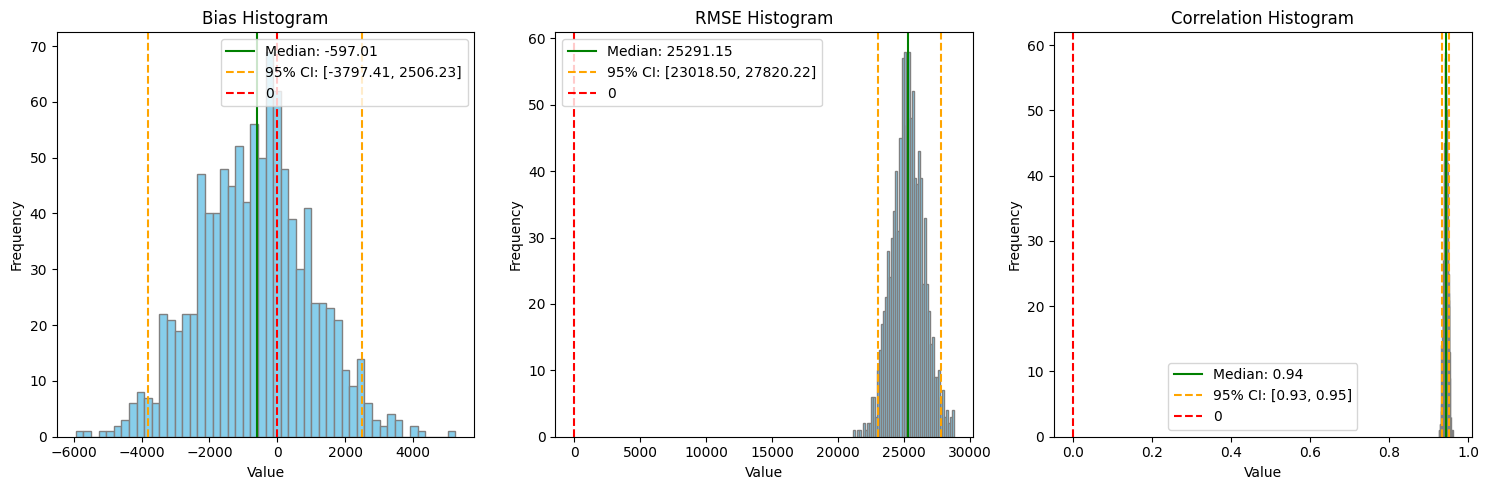

In [55]:
import matplotlib.pyplot as plt
import numpy as np

metric_names = ['Bias', 'RMSE', 'Correlation']

fig, axes = plt.subplots(1, len(metric_names), figsize=(len(metric_names) * 5, 5))

for ax, name in zip(axes, metric_names):
    data = metrics[name]
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(0, color='red', linestyle='--', label='0')
    
    ax.set_title(f'{name} Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()
